In [2]:
import os
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langchain_chroma import Chroma
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools import DuckDuckGoSearchRun


load_dotenv()
nvidia_api_key = os.getenv("NVIDIA_API_KEY")

llm = ChatNVIDIA()
parser = StrOutputParser()

embeddings = NVIDIAEmbeddings(
    model="nvidia/nv-embedqa-e5-v5",
    model_type="passage",
    api_key=nvidia_api_key
)

vector_store = Chroma(
    persist_directory='hands-on-ml1',
    embedding_function=embeddings,
    collection_name='hands-on-ml'
)


class Agentstste(TypedDict):
    agent_response : str
    question: str
    retrieved_docs: str
    grade_response: str
    answer: str
    rewrite_count: int


def should_respond_direct_or_retrieve_doc(state : Agentstste):
    print('\nNode: should_respond_direct_or_retrieve_doc')
    prompt = PromptTemplate(
        template="""You are an expert at routing questions either to a book content search or answering directly.

The vector store contains book content including chapters, pages, and sections from a comprehensive book.

Based on the question, decide if you should retrieve relevant book content or respond directly without retrieval.

- If the question requires referencing the book, respond ONLY with "related to vector store".
- If the question is general or outside book content, respond ONLY with "direct respond".

Question:
{question}

Respond ONLY with "related to vector store" or "direct respond".""",
        input_variables=['question']
    )
    chain = prompt | llm | parser
    result = chain.invoke({'question': state['question']})
    state['agent_response'] = result

    if result == 'direct respond':
        state['answer'] = llm.invoke(state['question']).content
        print('\n direct response')

    return state


# routing function
def should_respond_direct_or_retrieve_doc_condition(state : Agentstste):
     
    if state['agent_response'] == 'direct respond':
        return "responded directly"
    elif state['agent_response'] == 'related to vector store':
        return "related to vectore store"


def retrive_docs(state: Agentstste):
    print('Node: Retrieve Docs')
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 30})
    docs = retriever.invoke(state["question"])
    state["retrieved_docs"] = "\n\n".join(doc.page_content for doc in docs)
    return state

def grade(state: Agentstste):
    print('\nNode: Grade Context')
    prompt = PromptTemplate(
        template="""You are a book content expert. Determine if the retrieved book text is relevant and sufficient to answer the question.

Question:
{question}

Book Content:
{retrieved_docs}

Respond ONLY with "yes" if relevant or "no" if not.""",
        input_variables=['question', 'retrieved_docs']
    )
    chain = prompt | llm | parser
    result = chain.invoke({'question': state['question'], 'retrieved_docs': state['retrieved_docs']})
    state['grade_response'] = result
    return state

# routing function
def grade_condition(state: Agentstste) -> str:
    return state["grade_response"].strip().lower()

def generate_using_retrieved_docs(state: Agentstste):
    print('\n Node: Generate Answer using retrieved docs')
    prompt = PromptTemplate(
        template="""You are a knowledgeable book reader and explainer. Use ONLY the provided book content to answer the question.

Question:
{question}

Book Content:
{retrieved_docs}

Answer clearly with references to chapters, page numbers, or sections if applicable. Use examples or quotes from the book where relevant.""",
        input_variables=['question', 'retrieved_docs']
    )
    chain = prompt | llm | parser
    state['answer'] = chain.invoke({'question': state['question'], 'retrieved_docs': state['retrieved_docs']})
    return state

def rewrite_question(state: Agentstste):
    print('Node: Rewrite Question')
    state['rewrite_count'] += 1
    if state['rewrite_count'] > 3:
        raise Exception("Maximum rewrite attempts reached.")
    prompt = PromptTemplate(
        template="""Rewrite the following question to make it clearer and better matched to book content retrieval:

Original Question:
{question}
""", input_variables=['question']
    )
    chain = prompt | llm | parser
    state['question'] = chain.invoke({'question': state['question']})
    return state


# graph building
graph = StateGraph(Agentstste)

graph.add_node("should_respond_direct_or_retrieve_doc",should_respond_direct_or_retrieve_doc)
graph.add_node("retrive_docs", retrive_docs)
graph.add_node("grade", grade)
graph.add_node("generate_answer_using_retrieved_docs", generate_using_retrieved_docs)
graph.add_node("rewrite_question", rewrite_question)

graph.add_edge(START, 'should_respond_direct_or_retrieve_doc')
graph.add_conditional_edges("should_respond_direct_or_retrieve_doc", should_respond_direct_or_retrieve_doc_condition, {
    "related to vectore store": "retrive_docs",
    "responded directly": END
})
graph.add_edge('retrive_docs', 'grade')
graph.add_conditional_edges("grade", grade_condition, {
    "yes": "generate_answer_using_retrieved_docs",
    "no": "rewrite_question"
})
graph.add_edge('rewrite_question', 'should_respond_direct_or_retrieve_doc')
graph.add_edge("generate_answer_using_retrieved_docs", END)

app = graph.compile()


In [3]:

initial_state1 = Agentstste(question='what is diffrence between reinforecemnt and supervised ?',rewrite_count=0)
response = app.invoke(initial_state1)

print("\n Final Question:", response['question'])
print("✅ Final Answer:\n", response['answer'])


Node: should_respond_direct_or_retrieve_doc
Node: Retrieve Docs

Node: Grade Context

 Node: Generate Answer using retrieved docs

 Final Question: what is diffrence between reinforecemnt and supervised ?
✅ Final Answer:
 According to the book, Reinforcement Learning is a type of learning where the system learns through trial and error by interacting with an environment and receiving rewards or penalties for its actions.

Supervised learning, on the other hand, involves training a model on labeled data, where the model is trained to produce a specific output for a given input.

The book explains that RBMs (Restricted Boltzmann Machines) are typically trained sequentially in an unsupervised manner, and then fine-tuned using supervised learning techniques (Section "Reinforcement Learning", emphasis added).

In contrast, supervised learning involves providing the training set with the desired solutions, called labels (Figure 1-5). The system learns to make predictions by mapping inputs t

In [4]:

initial_state1 = Agentstste(question='what is diffrence types  of ML ?',rewrite_count=0)
response = app.invoke(initial_state1)

print("\n Final Question:", response['question'])
print("✅ Final Answer:\n", response['answer'])


Node: should_respond_direct_or_retrieve_doc
Node: Retrieve Docs

Node: Grade Context

 Node: Generate Answer using retrieved docs

 Final Question: what is diffrence types  of ML ?
✅ Final Answer:
 According to the book, there are different types of Machine Learning systems, which can be classified based on the following criteria:

1. Whether or not they are trained with human supervision (supervised, unsupervised, semisupervised, and Reinforcement Learning) (Section: Types of Machine Learning Systems, page 7).
2. Whether or not they can learn incrementally on the fly (online versus batch learning) (Section: Types of Machine Learning Systems, page 14).
3. Whether they work by simply comparing new data points to known data points, or instead by detecting patterns in the training data and building a predictive model, much like scientists do (instance-based versus model-based learning) (Section: Types of Machine Learning Systems, page 9).

These criteria are not exclusive, and different 

In [5]:

initial_state1 = Agentstste(question='what is diffrence types of non  linear regression ?',rewrite_count=0)
response = app.invoke(initial_state1)

print("\n Final Question:", response['question'])
print("✅ Final Answer:\n", response['answer'])


Node: should_respond_direct_or_retrieve_doc
Node: Retrieve Docs

Node: Grade Context

 Node: Generate Answer using retrieved docs

 Final Question: what is diffrence types of non  linear regression ?
✅ Final Answer:
 According to the book, there are no explicit types of non-linear regression mentioned. However, it mentions Polynomial Regression, Ridge Regression, and Lasso Regression as ways to fit non-linear datasets.

Polynomial Regression is a more complex model that can fit non-linear datasets by adding powers of each feature onto the linear model (Section 4.4, page 128). It can be used to fit non-linear relationships, such as "if x is close to 0, then y generally goes up" (Section 4.4, page 128).

Ridge Regression and Lasso Regression are regularized versions of Linear Regression that can be used to fit non-linear datasets. Ridge Regression adds a regularization term to the cost function using half the square of the ℓ2 norm of the weight vector (Equation 4-10), while Lasso Regres

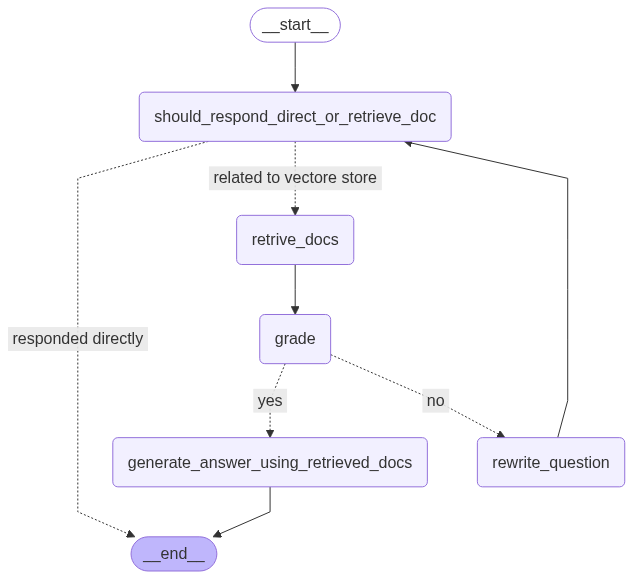

In [6]:

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))